<a href="https://colab.research.google.com/github/BPDanek/keiji_misc/blob/main/PatientAnalyticsDemoNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>  </center>

TrialMind by Keiji.AI is a Generative AI assistant designed to support several Clinical Trial operations, research, and analytics activities. This notebook is used to demonstrate the Patient Trial Analytics Agent instantieted for the Medidata Simulants product.

Find out more at: https://keiji.ai/

Some suggested questions you can ask our agent:

Co-pilot mode:
- in python, how would I display a summary of the data actually contained in ADCM
- Plot the top 10 most frequent medications*
- show me the patient journey with just the study treatment start and end
- plot overall survival
- Plot a single patient timeline with death date*
- Plot the patient journeys when sorted by death date*
- plot a patient journey with the timeline events: start, responses, death, and last follow up*
- plot progression free survival*
- plot overall survival*
- Can you generate the timeline plots for all subjects, keep pre-conditioning therapies and ICANs?
- Please find the adverse effects that are related to Immune effector cell-associated neurotoxicity syndrome (ICANS)
- Suppose I have a trial with the phase 2 outcome measure Objective Response Rate. How would I determine that?
- Could you help me find the adverse effects that are related to Immune effector cell-associated neurotoxicity syndrome (ICANS)?
- Could you write a python script to find the optimal pre-conditioning regimens to minimize ICANs? Use logistic regression to measure feature importance.

Non-co-pilot (vanilla) mode:
- I want to perform an analysis on the dataset that highlights the endpoints: overall response rate, overall survival or progression free survival. What can I learn from this kind of analysis?
- I have a trial with the phase 2 outcome measure Objective Response Rate. How would I determine that quantity? My dataset is based on CDISC ADaM|

*: make nice visualizations

# Setting Up the Notebook

To setup the notebook, the CDISC ADaM files representing the dataset must be uploaded.

1. in the left hand navigation bar, open the file folder (below the key icon) (altname: Files)
2. Upload the provided dataset into the opened folder. This can be done by dragging the 10 ADaM files into the space below the `..` folder

<center> 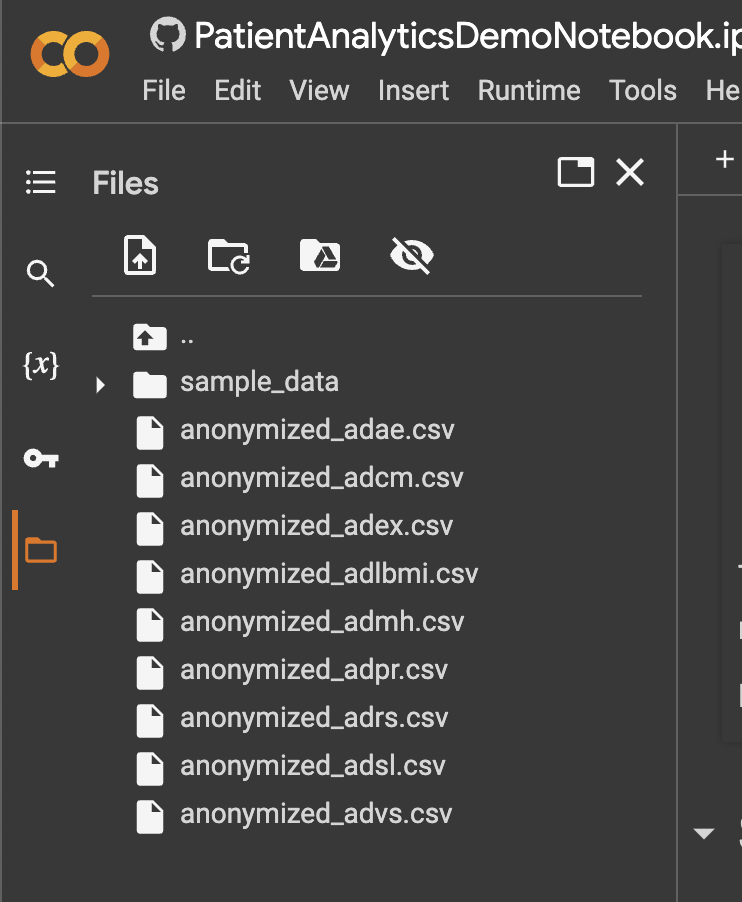 </center>

By the end of this process the directory `/content` should contain the files
```
anonymized_adae.csv
anonymized_adcm.csv
anonymized_adex.csv
anonymized_adlbmi.csv
anonymized_admh.csv
anonymized_adpr.csv
anonymized_adrs.csv
anonymized_adrs.csv
anonymized_adsl.csv
anonymized_advs.csv
```



# Import Dataset and Perform Standard Preprocessing

In [ ]:
!pip install lifelines

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import random
import scipy.interpolate
from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
import datetime
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings('ignore')

# load the data
path = "/content/"

adsl = pd.read_csv(path+'anonymized_adsl.csv', index_col=0)
adlb = pd.read_csv(path+'anonymized_adlbmi.csv')
advs = pd.read_csv(path+'anonymized_advs.csv')
adcm = pd.read_csv(path+'anonymized_adcm.csv')
adrs = pd.read_csv(path+'anonymized_adrs.csv')
adpr = pd.read_csv(path+'anonymized_adpr.csv')
adae = pd.read_csv(path+'anonymized_adae.csv')
adex = pd.read_csv(path+'anonymized_adex.csv')
admh = pd.read_csv(path+'anonymized_admh.csv')

## Predefined processing functions
def multitimeline(df_dict: dict,
                  common_uid: str = 'USUBJID',
                  uid_select: pd.NA = pd.NA,
                  order_by: str = 'x_start',
                  bin_correct_ends: bool = True,
                  days_to_autoadd: int = 1,
                  bin_create_dates_from_days: bool = True):
    '''
    Ingests a list of event-level datasets and creates a single, unified timeline.

    Args:
        df_dict (dict): Dictionary containing event-level datasets.
        common_uid (str, optional): Column name for common unique identifier. Defaults to 'USUBJID'.
        uid_select (pd.NA, optional): Value to filter the `common_uid` column for. Defaults to pd.NA.
        order_by (str, optional): Column name to order the timeline. Defaults to 'x_start'.
        bin_correct_ends (bool, optional): Whether to correct the end values. Defaults to True.
        days_to_autoadd (int, optional): Number of days to add for automatic padding. Defaults to 1.
        bin_create_dates_from_days (bool, optional): Whether to tranforms days into dates using today as the reference point. Defaults to True.

    Returns:
        tuple: A tuple containing the timeline data frame and the timeline plot.

    Raises:
        ValueError: If `df_dict` is not a dictionary or if it doesn't contain required keys.
        KeyError: If any required keys are missing in `df_dict`.
    '''

    # Validate input dictionary
    if not isinstance(df_dict, dict):
        logging.error("The input 'df_dict' must be a dictionary.")
        raise ValueError("Input 'df_dict' must be a dictionary.")

    required_keys = ['df', 'x_start', 'x_end', 'label']
    missing_keys = [key for key in required_keys if key not in df_dict.get(next(iter(df_dict)), {})]
    if missing_keys:
        logging.error(f"Missing required key(s) in 'df_dict': {', '.join(missing_keys)}")
        raise KeyError(f"Missing required key(s) in 'df_dict': {', '.join(missing_keys)}")

    dfs = []

    for key, data in df_dict.items():
        # Extract required columns from data frame and add color column if available
        temp_df = data['df'][[common_uid, data['x_start'], data['x_end'], data['label']]]
        if 'color' in data:
            temp_df['color'] = key + ':' + data['color'].astype(str)
        else:
            temp_df['color'] = key + ':'

        # Filter data frame based on common_uid and drop rows with missing values
        temp_df = temp_df[temp_df[common_uid] == uid_select].dropna()

        temp_df.columns = [common_uid, 'x_start', 'x_end', 'label', 'color']

        if temp_df.empty:
            continue

        if bin_create_dates_from_days:
            now = datetime.datetime.now()
            # Convert time variables from days to dates using current date as reference
            temp_df['x_start'] = now + pd.to_timedelta(temp_df['x_start'], unit='D')
            temp_df['x_end'] = now + pd.to_timedelta(temp_df['x_end'], unit='D')
        else:
            # Convert x_start and x_end columns to datetime if they are not already
            temp_df['x_start'] = pd.to_datetime(temp_df['x_start'])
            temp_df['x_end'] = pd.to_datetime(temp_df['x_end'])

        # Create a new column, x_start+1, by adding days_to_autoadd to x_start
        temp_df['x_start+1'] = temp_df['x_start'] + pd.DateOffset(days=days_to_autoadd)
        # Correct x_end values by taking the maximum between x_end and x_start+1
        temp_df['x_end corr'] = temp_df[['x_end', 'x_start+1']].max(axis=1)

        dfs.append(temp_df)

    # Concatenate the data frames from all datasets
    if len(dfs) == 0:
        return None, None
    else:
        tl_df = pd.concat(dfs).sort_values(order_by)[['x_start', 'x_end corr', 'label', 'color']].dropna()

    if tl_df.empty:
        logging.warning("The timeline data frame is empty.")
        return None, None

    try:
        # Generate the timeline plot using the timeline data frame
        if bin_correct_ends:
            plot = px.timeline(tl_df, x_start='x_start', x_end='x_end corr', y="label", color='color')
        else:
            plot = px.timeline(tl_df, x_start='x_start', x_end='x_end', y="label", color='color')
    except Exception as e:
        logging.error("Error occurred while generating the timeline plot.")
        logging.error(str(e))
        return None, None

    return tl_df.sort_values(by = "x_start"), plot


def bor_from_timeline(tl_df_: pd.DataFrame,
                      uid: str,
                      start_event: str = '0. 1L Treatment:',
                      overall_response_event: str = '1. Overall Response:',
                      end_event: str = '3. Last Date:',
                      bor_rank: list = ['CR', 'CMR', 'CRH', 'IRCR', 'CRi', 'CRI', 'REMISSION', 'PR/CR',
                                        'IRPR', 'PR', 'PMR', 'SD', 'IRSD', 'NO RESPONSE', 'SMD',
                                        'PD', 'RELAPSED DISEASE', 'RELAPSE', 'PMD', 'IRPD'],
                      bor_to_drop: list = ['NE', 'U', 'UNKNOWN', 'BFBM (BLAST-FREE HYPOPLASTIC OR APLASTIC BM)',
                                           'NR', 'Missing/Unknown', 'NON-CR/NON-PD'],
                      end_of_bor: list = ['PD', 'RELAPSED DISEASE', 'RELAPSE', 'PMD', 'IRPD'],
                      positive_response: list = ['CR', 'CMR', 'CRH', 'IRCR', 'CRi', 'CRI',
                                                 'REMISSION', 'IRPR', 'PR', 'PMR', 'PR/CR'],
                      next_tx_end_of_bor = True):
  '''
  Creates best overall response dataframe based on individual timeline. Intended to be called subject by subject by providing one `uid` at a time.

  Args:
        tl_df (pd.DataFrame): timeline dataframe for a patient.
        uid (str): patient identifier for which tl_df was provided.
        start_event (str, optional): category in 'color' column of `tl_df` representing the treatment event. Defaults to '0. 1L Treatment:'.
        overall_response_event (str, optional): category in 'color' column of `tl_df` representing the overall response. Defaults to '1. Overall Response:'.
        end_event (str, optional): category in 'color' column of `tl_df` representing the end event. Defaults to '3. Last Date:'.
        bor_rank (list, optional): list of responses ordered from "best" to "worst.
        bor_to_drop (list, optional): list of responses to ignore.
        end_of_bor (list, optional): list of responses that represent the end of best-overall-response period.
        positive_response (list, optional): list of responses that are positive response to the treatment.
        death_end_of_bor (bool, optional): whether to include death as an end of BOR event. Defaults to True.
        next_tx_end_of_bor (bool, optional): whether to include new treatment lines as an end of BOR event. Defaults to True.
        value_new_tx_filter (list, optional): list of the medications considered new lines of tx. Defaults to [].

  Returns:
        pd.DataFrame: dataframe with calculated (best) overall response and associated timelines
  '''

  tl_df = tl_df_.copy()

  bor_df = pd.DataFrame(index=[uid], columns = ['FLAG_TTR', 'OR_TTR', 'TTR', 'BOR',
                                                'TTE_BOR', 'FLAG_END_OF_BOR',
                                                'END_OF_BOR_TYPE', 'FLAG_DOR', 'TTE_DOR',
                                                'DOR_BOR', 'FLAG_PFS','TTE_PFS',
                                                'FLAG_OS', 'TTE_OS'])

  zero_date = tl_df.loc[tl_df.loc[:, 'color'] == start_event, 'x_start'].min()
  last_date = tl_df.loc[tl_df.loc[:, 'color'] == end_event, 'x_start'].max()



  #################################################
  ### SECTION: SET UP OF THE TIMELINE DATAFRAME ###
  #################################################

  # If death is to be included as an end of BOR event
  tl_death_idx = tl_df.color.str.contains("DEATH", case=False)
  tl_df.loc[tl_death_idx, "label"] = "Death"
  tl_df.loc[tl_death_idx, "color"] = overall_response_event

  end_of_bor = end_of_bor + ["Death"]
  bor_rank = bor_rank + ["Death"]


  bor_dict = {bor_rank[i]: i for i in range(len(bor_rank))}
  for bor in bor_to_drop:
    bor_dict[bor] = np.nan

  # Assign rank to response events according to bor_rank
  tl_df.loc[tl_df.label.isin(bor_rank), 'label_rank'] = tl_df.loc[tl_df.label.isin(bor_rank), 'label'].replace(bor_dict)

  # If new tx lines post CART are to be included as a censoring event
  if next_tx_end_of_bor:
    list_new_tx = list(tl_df[tl_df.color.str.contains("TREATMENT", case = False)].label)
    end_of_bor = list(set(end_of_bor).union(set(list_new_tx)))
    tl_new_tx_idx = tl_df.label.isin(list_new_tx)
    tl_df.loc[tl_new_tx_idx, "color"] = overall_response_event
  else:
    list_new_tx = []

  # If new lines of tx are to be included as censoring events
  if next_tx_end_of_bor:
    tl_new_tx_idx = tl_df.label.isin(list_new_tx)
    if tl_new_tx_idx.sum() > 0:
      new_tx_date = tl_df.loc[tl_new_tx_idx, "x_start"].min()
    else:
      new_tx_date = last_date + pd.DateOffset(days = 3)

  else:
    new_tx_date = last_date + pd.DateOffset(days = 3)

  # Censoring date is the first of the last follow up date and new tx date
  last_censored_date = min(new_tx_date, last_date)

  # If the patient experienced death
  if tl_df.loc[tl_death_idx, "label"].shape[0] > 0:
    death_date = tl_df.loc[tl_death_idx, "x_start"].min()
    # Including death as a censoring event
    last_censored_date = min(last_censored_date, death_date)
  else:
    death_date = last_date + pd.DateOffset(days = 3)

  # Checking if the patient has a record of SD before new tx line, death or end of follow up
  tl_SD_idx = tl_df[(tl_df.x_start <= last_censored_date)&(
      tl_df.x_start >= zero_date)].label.astype(str).str.contains("SD", case = False)
  if tl_SD_idx.sum():
    print(uid)
    last_SD_date = tl_df[(tl_df.x_start <= last_censored_date)&(
      tl_df.x_start >= zero_date) & (
          tl_df.label.astype(str).str.contains("SD", case = False))].loc[tl_SD_idx, "x_start"].max()
    last_SD_day = (last_SD_date - zero_date).days
    flag_SD_before_censoring = True

  else:
    flag_SD_before_censoring = False
    last_SD_date = last_censored_date
    last_SD_day = (last_SD_date - zero_date).days


  #################################################
  ### SECTION: OVERALL SURVIVAL CALCULATION ###
  #################################################

  last_follow_up = (last_censored_date  - zero_date).days

  # Calculating the OS if the patient dies before the censoring event
  if (tl_df.loc[tl_death_idx, "label"].shape[0] > 0):
    death_days = (death_date - zero_date).days

    if  death_date <= last_censored_date:
      bor_df.loc[uid, 'TTE_OS'] = death_days
      flag_OS = True

    else:
      bor_df.loc[uid, 'TTE_OS'] = last_follow_up
      flag_OS = False


  else:
  # Calculating the OS if no death
    bor_df.loc[uid, 'TTE_OS'] = last_follow_up
    flag_OS = False

  bor_df.loc[uid, 'FLAG_OS'] = flag_OS



  #################################################
  ### SECTION: BOR CALCULATION ###
  #################################################

  # Define the start of best overall response (BOR)
  bor_start_data = tl_df.copy()
  bor_start_data = bor_start_data.loc[(bor_start_data.loc[:, 'color'] == overall_response_event) &
   (bor_start_data.loc[:, 'x_start'] > zero_date) &
   (bor_start_data.loc[:, 'x_start'] <= last_censored_date), :] # select responses between the start date and censor date

  bor_start_data = bor_start_data.sort_values(['label_rank', 'x_start']) # sort responses from best to worst and by date
  bor_start_data = bor_start_data.dropna() # remove any missing responses

  if bor_start_data.shape[0] > 0: # check to make sure there is at least one response recorded
    bor_start_data = bor_start_data.iloc[0, :]
    bor_start_date = bor_start_data.loc['x_start']
    bor_df.loc[uid, 'TTE_BOR'] = (bor_start_date - zero_date).days # time to event for the Best Overall Response
    bor_df.loc[uid, 'BOR']     = bor_start_data.loc['label'] # what is the best overall response?
  else:
    return bor_df


  #################################################
  ### SECTION: OR CALCULATION ###
  #################################################

  # Define the start of the response (CR or PR)
  or_start_data = tl_df.copy()
  or_start_data = or_start_data.loc[(or_start_data.loc[:, 'color'] == overall_response_event) &
    (or_start_data.loc[:, 'x_start'] > zero_date) & # select responses after the start date
    (or_start_data.loc[:, 'x_start'] <= last_censored_date), :] # select responses before the censoring date
  or_start_data = or_start_data[or_start_data["label"].isin(positive_response)] # Filtering only for the PR or CR events


  or_start_data = or_start_data.sort_values(['x_start']) # sort responses by date
  or_start_data = or_start_data.dropna() # remove any missing responses

  if or_start_data.shape[0] > 0: # check to make sure there is at least one positive response recorded
    or_start_data = or_start_data.iloc[0,:]
    or_start_date = or_start_data.loc['x_start']
    bor_df.loc[uid, 'TTR'] = (or_start_date - zero_date).days # time to event for the first of any positive response (PR or CR)
    bor_df.loc[uid, 'OR_TTR'] = or_start_data.loc['label'] # which type of response is the first positive response?
    bor_df.loc[uid, 'FLAG_TTR'] = True

    bor_end_data = tl_df.loc[(tl_df.loc[:,'color'] == overall_response_event) &
        (tl_df.loc[:, 'label'].isin(end_of_bor)) &
        (tl_df.loc[:, 'x_start'] >  bor_start_date), :]
        # If the patient experiences a positive response,
        # look at the end of response events only after the date of the BOR (NOT including the date of BOR)
  else:
    bor_df.loc[uid, 'FLAG_TTR'] = False # No response recorded, Flag set to False

    bor_end_data = tl_df.loc[(tl_df.loc[:, 'color'] == overall_response_event) &
        (tl_df.loc[:, 'label'].isin(end_of_bor)) &
        (tl_df.loc[:, 'x_start'] >=  bor_start_date), :]
        # If the patient does not experience a positive response,
        # look at the end of response events only after the date of the BOR (including the date of BOR).
        # Ex, if the BOR is a PD, measured on day 10, day 10 would be the day of the end of BOR

  #################################################
  ### SECTION: PFS CALCULATION ###
  #################################################

  if bor_end_data.shape[0] > 0: # if the patient experiences an end of BOR event
    bor_end_data = bor_end_data.sort_values(['x_start', 'color']) # sort responses by date (note that *any* end_of_bor response is sufficient to determine duration of BOR, best or worst does not matter)
    bor_end_data = bor_end_data.iloc[0, :]
    tte_end_bor  = (bor_end_data.loc['x_start'] - zero_date).days # Number of days from start day to end of BOR
    bor_df.loc[uid, 'END_OF_BOR_TYPE'] = bor_end_data.loc['label']

    ## Censoring rules for PFS and END_OF_BOR

    # If the end of END_OF_BOR_TYPE is within the events to be considered as end_of_bor
    if bor_df.loc[uid, 'END_OF_BOR_TYPE'] in list(set(end_of_bor) - set(list_new_tx) - set(["Death"])):
      flag_pfs_end_bor = True

    # If the patient receives new tx or experiences death, checking for any SD record before, and taking the last record:
    elif (bor_df.loc[uid, 'END_OF_BOR_TYPE'] in list_new_tx + ["Death"]):

      if (last_SD_day < tte_end_bor) & ( last_SD_date > bor_start_date):
        print(uid)
        tte_end_bor = last_SD_day
        bor_df.loc[uid, 'END_OF_BOR_TYPE'] = "SD"
        flag_pfs_end_bor = False

      # If the end of END_OF_BOR_TYPE is a new treatment line
      elif bor_df.loc[uid, 'END_OF_BOR_TYPE'] in list_new_tx:
        flag_pfs_end_bor = False

      # If the end of END_OF_BOR_TYPE is death
      elif bor_df.loc[uid, 'END_OF_BOR_TYPE'] == "Death":
        flag_pfs_end_bor = True

  # If no END_OF_BOR_TYPE recorded, the patient is censored on the last follow up date
  else:
    flag_pfs_end_bor = False
    tte_end_bor = (last_censored_date  - zero_date).days

    # If the patient is censored, checking for any SD record before the censoring, and taking the last record:
    if (last_SD_day < tte_end_bor)& ( last_SD_date > bor_start_date):
        print(uid)
        tte_end_bor = last_SD_day
        bor_df.loc[uid, 'END_OF_BOR_TYPE'] = "SD"


  bor_df.loc[uid, 'TTE_PFS'] = tte_end_bor # PFS: number of days leading to the end of BOR event.


  #################################################
  ### SECTION: DOR CALCULATION ###
  #################################################

  if bor_end_data.shape[0] > 0:
    ## Censoring rules for DOR
    if bor_df.loc[uid,'BOR'] in positive_response: # If the patient experiences a positive response

      # If the end of END_OF_BOR_TYPE is within the events to be considered as end_of_bor
      if bor_df.loc[uid, 'END_OF_BOR_TYPE'] in list(set(end_of_bor) - set(list_new_tx) - set(["Death"])):
        flag_dor = True

        # If the patient receives new tx or experiences death, checking for any SD record before, and taking the last record:
      elif (bor_df.loc[uid, 'END_OF_BOR_TYPE'] in list_new_tx + ["Death"]):

        # Censoring at last SD record
        if (last_SD_day < tte_end_bor) & ( last_SD_date > bor_start_date):
          flag_dor = False

        # If the end of END_OF_BOR_TYPE is a new treatment line
        elif bor_df.loc[uid, 'END_OF_BOR_TYPE'] in list_new_tx:
          flag_dor = False

        # If the end of END_OF_BOR_TYPE is death
        elif bor_df.loc[uid, 'END_OF_BOR_TYPE'] == "Death":
          flag_dor = True

      # If no END_OF_BOR_TYPE recorded, the patient is censored on the last follow up date
      else:
        flag_dor = False

    else: # No positive response recorded
      flag_dor = False

  else: # No end of BOR event, the end date is the censoring date
    flag_dor = False


  bor_df.loc[uid, 'FLAG_PFS'] = flag_pfs_end_bor
  bor_df.loc[uid, 'FLAG_END_OF_BOR'] = flag_pfs_end_bor
  bor_df.loc[uid, 'FLAG_DOR'] = flag_dor


  if bor_df.loc[uid, 'BOR'] in positive_response: # if the patient experiences a positive response, we can calculate the DOR
    bor_df.loc[uid, 'DOR_BOR'] = tte_end_bor - bor_df.loc[uid, 'TTE_BOR'] # Time in days from BOR to an end of BOR event (e.g. PD, Relapse, Death)
    bor_df.loc[uid, 'TTE_DOR'] = tte_end_bor - bor_df.loc[uid, 'TTR'] # Duration of Response


  return bor_df

# List of new treatments medications that are to be considered as censoring events
value_new_tx_censor = []


# Defaults values for new treatments medications that are to be considered as censoring events
if value_new_tx_censor == []: value_new_tx_censor = list(set(adcm.loc[adcm.CMCAT=='POST ANTI-CANCER THERAPY',:].CMDECOD))

tl_dict = { 'START' : {'df'      : adsl,
                                    'x_start' :'PJSTDY',
                                    'x_end'   :'PJENDY',
                                    'label'   :'TRTARM'},

            'EVENTS - RESPONSES': {'df'      : adrs.loc[adrs.APARAM.str.contains('Overall Response'),:],
                                    'x_start' :'ADY',
                                    'x_end'   :'ADY',
                                    'label'   :'AVALC'},


            'EVENTS - DEATH'           : {'df'     : adsl,
                                    'x_start':'DTHDY',
                                    'x_end'  :'DTHDY',
                                    'label'  :'DTHDY'},

            'LAST FOLLOW UP'        : {'df'     : adsl,
                                    'x_start':'LASTPDY',
                                    'x_end'  :'LASTPDY',
                                    'label'  :'LASTPDY'},


            'CENSORING - NEW TREATMENTS'  : {'df'      : adcm.loc[(adcm.CMCAT=='POST ANTI-CANCER THERAPY')
                                                        & (adcm.CMDECOD.isin(value_new_tx_censor)),:],
                                    'x_start' :'ASTDY',
                                    'x_end'   :'AENDY',
                                    'label'   :'CMDECOD'}


          }

#### Label ethg as either censoring or events

start_event = 'START:'
overall_response_event = 'EVENTS - RESPONSES:'
end_event = 'LAST FOLLOW UP:'
bor_rank   = ['CR','CMR','CRH','IRCR','CRi','CRI','REMISSION',"PR/CR",
                                    'IRPR','PR','PMR','SD','IRSD','NO RESPONSE','SMD',
                                    'PD','RELAPSED DISEASE','RELAPSE','PMD','IRPD']

bor_to_drop = ['NE','U','UNKNOWN','BFBM (BLAST-FREE HYPOPLASTIC OR APLASTIC BM)', 'NR','Missing/Unknown','NON-CR/NON-PD']
end_of_bor = ['PD','RELAPSED DISEASE','RELAPSE','PMD','IRPD']
positive_response = ['CR','CMR','CRH','IRCR','CRi','CRI','REMISSION',
                                    'IRPR','PR','PMR',"PR/CR"]
next_tx_end_of_bor = True

ct = 0
bor_dfs = []
tl_dfs  = []

pt_ids  = adsl.USUBJID.unique()

# currently this loop is not optimized for time, but it will produce one timeline dataframe & one best-overall-response vector for each subject
for pt_id in pt_ids:
    ct += 1
    if ct % 100 == 1:
      print(ct,'out of',len(pt_ids))

    # creating the timeline for the specific patient
    tl_df, fig = multitimeline(df_dict=tl_dict,
                               common_uid='USUBJID',
                               uid_select=pt_id,
                               order_by='color',
                               days_to_autoadd=10)

    try:
      bor_df = None

      # From the timeline calculating the response events
      bor_df = bor_from_timeline(tl_df_ =tl_df,
                                 uid=pt_id ,
                                 start_event=start_event,
                                 overall_response_event=overall_response_event,
                                 end_event=end_event,
                                 bor_rank=bor_rank,
                                 bor_to_drop=bor_to_drop,
                                 end_of_bor=end_of_bor,
                                 positive_response=positive_response,
                                 next_tx_end_of_bor = next_tx_end_of_bor)
      bor_dfs.append(bor_df)
      tl_df.index = [(pt_id, i) for i in tl_df.reset_index().index]
      tl_dfs.append(tl_df)
    except:
      print('ERROR', pt_id)
      display(tl_df)
      display(bor_df)
      break

bor_df        = pd.concat(bor_dfs)
pt_journey_df = pd.concat(tl_dfs)

pt_journey_df.index = pd.MultiIndex.from_tuples(pt_journey_df.index.tolist()) # generates a hierarchical index for the concatenated patient journey dataframe

bor_df= bor_df[["FLAG_TTR",'OR_TTR', 'TTR','BOR','TTE_BOR','FLAG_END_OF_BOR','END_OF_BOR_TYPE',"FLAG_DOR",'TTE_DOR',
                'DOR_BOR','FLAG_PFS','TTE_PFS',
                "FLAG_OS", "TTE_OS"]]

"|".join(bor_df.columns.tolist())

"|".join(pt_journey_df["color"].value_counts().index.tolist())

pt_journey_df

print(pt_journey_df.head(5).to_markdown())

adsl = bor_df.reset_index().rename(columns={"index":"USUBJID"}).merge(adsl, on="USUBJID")

FileNotFoundError: ignored

# Demo

Paste Code Generated by TrialMind Patient Analysis Co-Pilot below: